In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_reconstructions(encoder_decoder, X):
    
    idxs = np.random.randint(0,X.shape[0], size=10)
    reconstruction, params = encoder_decoder.predict(X[idxs])
    
    print(params[0])
   
    plt.figure(figsize=(16,3))
    for i in range(10):

        ax = plt.subplot(2,10,i+1)
        ax.imshow(reconstruction[i,:,:,0], cmap="gray", interpolation=None)
        ax = plt.subplot(2,10,10+i+1)
        ax.imshow(X[idxs[i],:,:,0], cmap="gray", interpolation=None)

    plt.show()

In [4]:
INTERMEDIATE_DIM = 30
LATENT_DIM = 10

EPOCHS = 100
INPUT_OUTPUT_CHANNELS = 1

In [5]:
import keras.backend as K

class SamplingLayer(keras.layers.Layer):
    
    def __init__(self, dimension):
        super(SamplingLayer, self).__init__()
        self._dimension = dimension
    
    def call(self, inputs):
        mean = inputs[:, :self._dimension]
        std = inputs[:, self._dimension:]
        eps = K.random_normal(K.shape(mean))

        return mean + std * eps

Using TensorFlow backend.


In [6]:
encoder = tf.keras.Sequential()
encoder.add(keras.layers.Conv2D(32, 3, strides=2, padding='same',
                                input_shape=[28, 28, INPUT_OUTPUT_CHANNELS]))
encoder.add(keras.layers.BatchNormalization())
encoder.add(keras.layers.LeakyReLU())

encoder.add(keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
encoder.add(keras.layers.BatchNormalization())
encoder.add(keras.layers.LeakyReLU())

encoder.add(keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
encoder.add(keras.layers.BatchNormalization())
encoder.add(keras.layers.LeakyReLU())

encoder.add(keras.layers.Flatten())

encoder.add(keras.layers.Dense(INTERMEDIATE_DIM, activation="relu"))
encoder.add(keras.layers.Dense(2 * LATENT_DIM, name="latent-mean-std"))


decoder = tf.keras.Sequential()
decoder.add(keras.layers.Input(2 * LATENT_DIM))
decoder.add(SamplingLayer(LATENT_DIM))
decoder.add(keras.layers.Dense(7*7*128, activation="relu"))
decoder.add(keras.layers.Reshape((7, 7, 128)))
decoder.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(keras.layers.BatchNormalization())
decoder.add(keras.layers.LeakyReLU())
decoder.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(keras.layers.BatchNormalization())
decoder.add(keras.layers.LeakyReLU())
decoder.add(keras.layers.Conv2DTranspose(INPUT_OUTPUT_CHANNELS, 3, strides=1, padding='same', activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
encoder_decoder = keras.Model(encoder.inputs, [decoder(encoder.output)] + encoder.outputs)

In [8]:
X = np.load("unknown_mnist.npy") / 255
X_train, X_test = np.expand_dims(X[:20000], axis=3), np.expand_dims(X[20000:], axis=3)

In [9]:
from keras.metrics import binary_crossentropy

def kl_loss_explicit_std(target, encoder_outputs):
    latent_dim = K.cast((K.shape(encoder_outputs)[1] / 2), "int32")
    mean = encoder_outputs[:, :latent_dim]
    std = K.abs(encoder_outputs[:, latent_dim:])
    
    per_sample_kl_loss = K.sum(K.square(mean)/2 + K.square(std)/2 - K.log(std) - 0.5, axis=1)

    return K.mean(per_sample_kl_loss) 

In [11]:
from keras.metrics import binary_crossentropy

def kl_loss(target, encoder_outputs):
    latent_dim = K.cast((K.shape(encoder_outputs)[1] / 2), "int32")
    mean = encoder_outputs[:, :latent_dim]
    log_var = K.abs(encoder_outputs[:, latent_dim:])
    log_sigma = log_var/2
    
    per_sample_kl_loss = K.sum(K.square(mean)/2 + K.exp(log_var)/2 - log_sigma - 0.5, axis=1)

    return K.mean(per_sample_kl_loss) 

def reconstruction_loss(x, x_decoded):
    x = K.reshape(x, (K.shape(x)[0], -1))
    x_decoded = K.reshape(x_decoded, (K.shape(x_decoded)[0], -1))
    
    return binary_crossentropy(x, x_decoded)

In [12]:
encoder_decoder.compile(keras.optimizers.Adam(0.001), loss=[reconstruction_loss, kl_loss_explicit_std],
                        loss_weights=[1, 0.001])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples
60000/60000 [==============================] - 187s 3ms/sample - loss: 0.2401 - sequential_1_loss: 0.2343 - latent-mean-std_loss: 5.7608
[ 0.54004544  2.002935    0.20365648 -0.12072917]


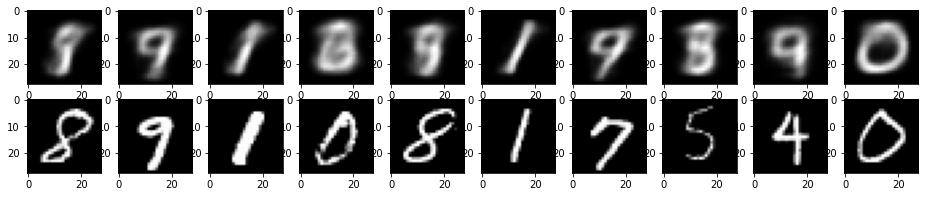

Train on 60000 samples
60000/60000 [==============================] - 158s 3ms/sample - loss: 0.2201 - sequential_1_loss: 0.2146 - latent-mean-std_loss: 5.5222
[ 1.1293982  -0.21827239  0.10374992  0.28202847]


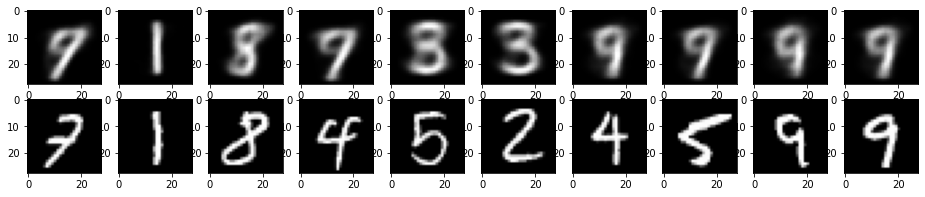

Train on 60000 samples
60000/60000 [==============================] - 183s 3ms/sample - loss: 0.2217 - sequential_1_loss: 0.2165 - latent-mean-std_loss: 5.2144
[-2.2067542   0.80490214 -0.8058697   0.27515933]


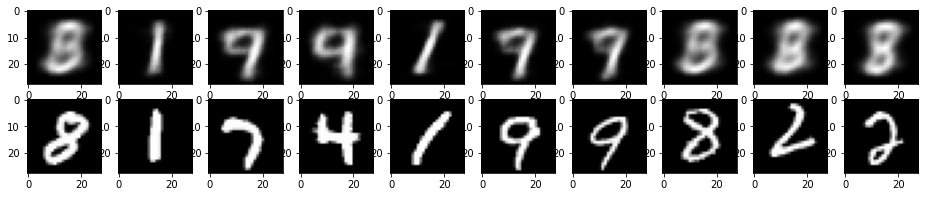

Train on 60000 samples
60000/60000 [==============================] - 181s 3ms/sample - loss: 0.2090 - sequential_1_loss: 0.2034 - latent-mean-std_loss: 5.5213
[-0.92691076 -0.4900315  -0.04091492 -0.04165685]


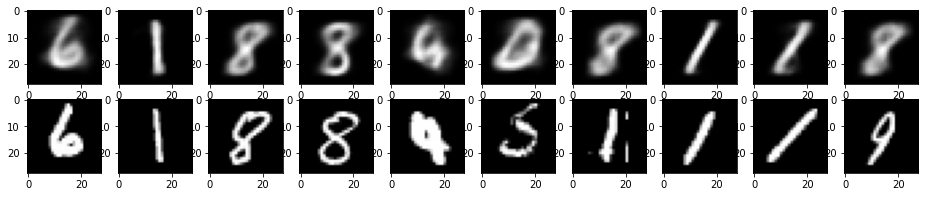

Train on 60000 samples
60000/60000 [==============================] - 182s 3ms/sample - loss: 0.2008 - sequential_1_loss: 0.1949 - latent-mean-std_loss: 5.8077
[ 0.69420695 -0.2676497  -0.06713696 -0.08520924]


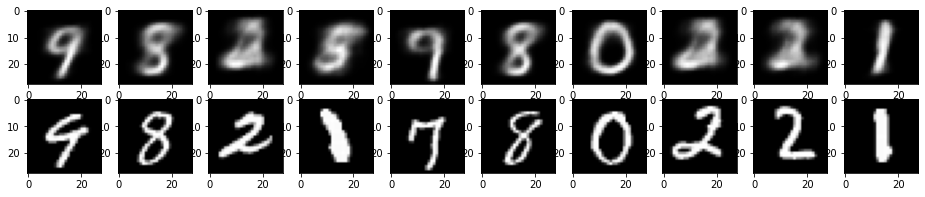

Train on 60000 samples
60000/60000 [==============================] - 178s 3ms/sample - loss: 0.1975 - sequential_1_loss: 0.1916 - latent-mean-std_loss: 5.9473
[-1.683485    0.31349212 -0.03296375 -0.10021821]


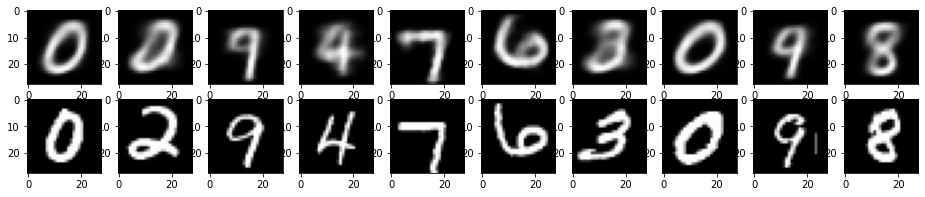

Train on 60000 samples
60000/60000 [==============================] - 183s 3ms/sample - loss: 0.1951 - sequential_1_loss: 0.1891 - latent-mean-std_loss: 6.0600
[-0.76999533 -0.86003375 -0.06853189 -0.03705043]


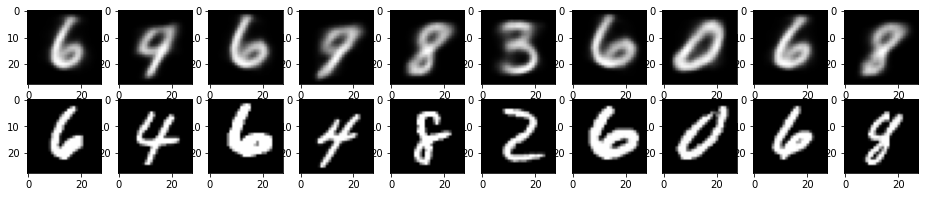

Train on 60000 samples
60000/60000 [==============================] - 187s 3ms/sample - loss: 0.1969 - sequential_1_loss: 0.1910 - latent-mean-std_loss: 5.9246
[-0.38168818 -1.1505071  -0.04124788  0.04449026]


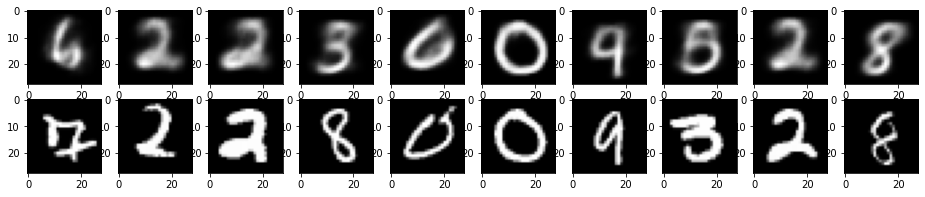

Train on 60000 samples
60000/60000 [==============================] - 205s 3ms/sample - loss: 0.1947 - sequential_1_loss: 0.1885 - latent-mean-std_loss: 6.2077
[ 1.8963544   2.067794   -1.3202244   0.24144633]


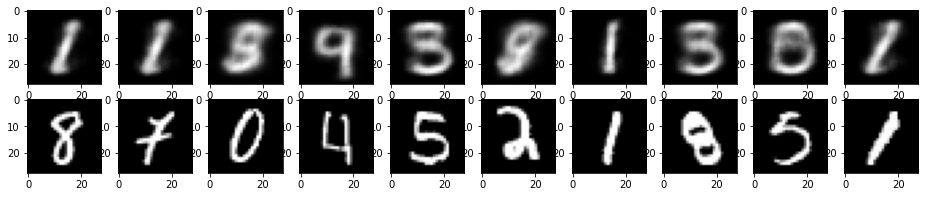

Train on 60000 samples
60000/60000 [==============================] - 185s 3ms/sample - loss: 0.2032 - sequential_1_loss: 0.1972 - latent-mean-std_loss: 5.9929
[-1.5608739  -0.39190394  0.05518907  0.03284169]


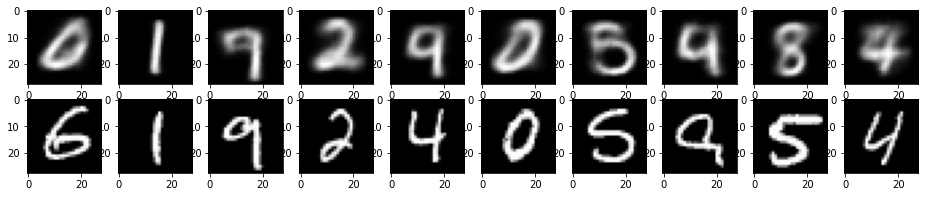

Train on 60000 samples
60000/60000 [==============================] - 195s 3ms/sample - loss: 0.1919 - sequential_1_loss: 0.1855 - latent-mean-std_loss: 6.3771
[0.1995328  0.5820677  0.05820716 0.0555093 ]


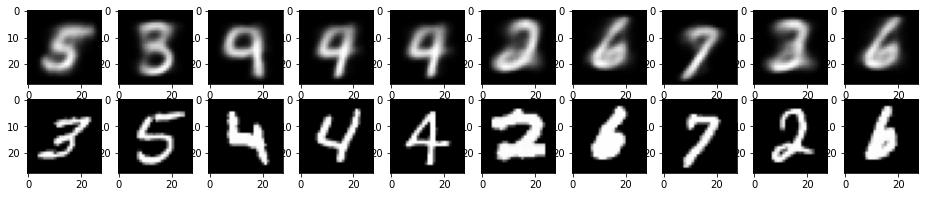

Train on 60000 samples
60000/60000 [==============================] - 186s 3ms/sample - loss: 0.2024 - sequential_1_loss: 0.1963 - latent-mean-std_loss: 6.0526
[ 4.083073    2.8405674   0.22953157 -1.8335322 ]


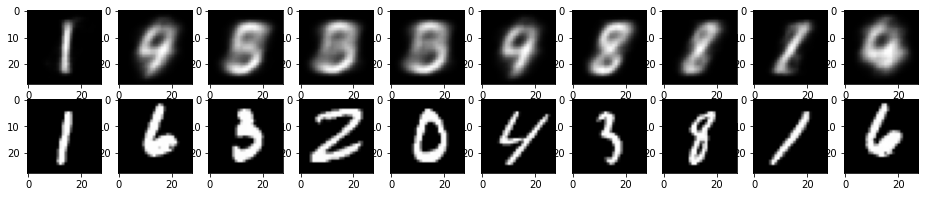

Train on 60000 samples
60000/60000 [==============================] - 189s 3ms/sample - loss: 0.1977 - sequential_1_loss: 0.1915 - latent-mean-std_loss: 6.1735
[0.64532614 1.0197031  0.0482268  0.0658421 ]


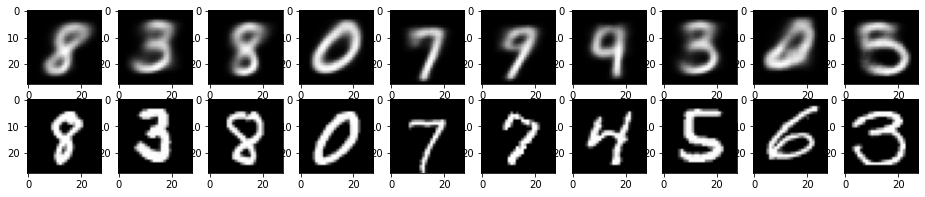

Train on 60000 samples
15328/60000 [======>.......................] - ETA: 2:27 - loss: 0.1912 - sequential_1_loss: 0.1848 - latent-mean-std_loss: 6.3639

KeyboardInterrupt: 

In [13]:
for i in range(EPOCHS):
    
    encoder_decoder.fit(X_train, [X_train, np.zeros((X_train.shape[0], 2*LATENT_DIM))], batch_size=32, epochs=1)
    
    plot_reconstructions(encoder_decoder, X_test)

In [25]:
encoder_decoder.evaluate(X_train, [X_train, np.zeros((X_train.shape[0], 2*LATENT_DIM))])

60000/60000 [==============================] - 26s 434us/sample - loss: 0.6936 - sequential_3_loss: 0.6935 - latent-mean-std_loss: 0.0016


[0.6935587578455608, 0.69352394, 0.0016196679]